### Calculate geoid height  using corrected geoid.


In [9]:
import xarray as xr
from glob import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import sample_from_raster 

In [16]:
path_lake_vec = 'data/siling_co-lake/hydrolake_siling_co.gpkg'
path_geoid_cor = 'data/siling_co-lake/swot-pixc/raster_geoid_cor_smoothed.nc'
dir_pixc = 'data/siling_co-lake/swot-pixc'
paths_pixc_filtered = sorted(glob(dir_pixc + '/*masked_filtered.nc'))  # Get the first .nc file in the directory
paths_pixc_filtered[0]


'data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_015_217_210L_20240516T015222_20240516T015234_PIC0_01_masked_filtered.nc'

In [17]:
## 1. read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
## 2. read corrected geoid data.
raster_geoid_cor = xr.open_dataset(path_geoid_cor)


In [18]:
pixcs_height_ds = []
for path_pixc_filtered in paths_pixc_filtered:
    pixc_filtered = xr.open_dataset(path_pixc_filtered)
    pixc_height_ds = pixc_filtered[['pixc_height_cor_filter2', 'geoid']]
    ## 1. extract the pixc corrected geoid from the raster data 
    pixc_geoid_cor = sample_from_raster(
        raster_value=raster_geoid_cor.geoid_cor_smoothed.values,
        raster_x = raster_geoid_cor.x.values,
        raster_y = raster_geoid_cor.y.values,
        points_x = pixc_filtered.longitude.values,
        points_y = pixc_filtered.latitude.values
        )
    pixc_height_ds = pixc_height_ds.assign({'geoid_cor': (("points",), pixc_geoid_cor)})
    ## 2. calculate pixc corrected geoid height
    pixc_height_geoid = pixc_filtered.pixc_height_cor_filter2.values
    pixc_height_ellip =  pixc_filtered.pixc_height_cor_filter2.values + pixc_height_ds['geoid'].values
    pixc_height_geoid_cor = pixc_height_ellip - pixc_geoid_cor
    pixc_height_ds = pixc_height_ds.assign({'height_geoid': (("points",), pixc_height_geoid)})
    pixc_height_ds = pixc_height_ds.assign({'height_geoid_cor': (("points",), pixc_height_geoid_cor)})
    pixcs_height_ds.append(pixc_height_ds)
    ### 3. save the pixc heights to a new NetCDF file
    path_pixc_height = path_pixc_filtered.replace('.nc', '_height.nc')
    # pixc_height_ds.to_netcdf(path_pixc_height)
    # print(f"Path to save: {path_pixc_height}")


Text(0.5, 1.0, 'pixc corrected geoid height(2024-06-05)')

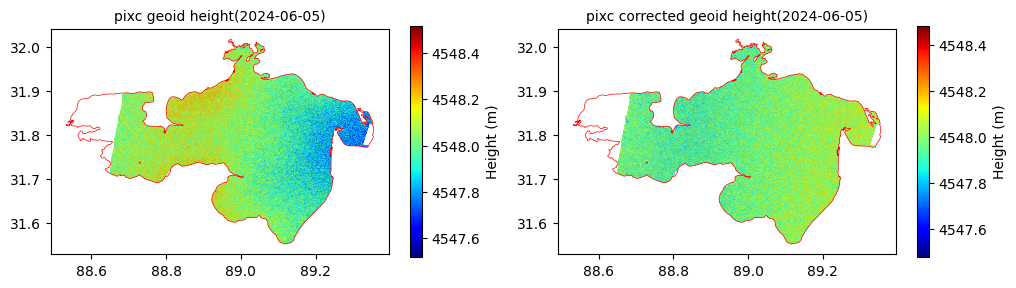

In [20]:
id = 1
height_geoid_mean = np.nanmean(pixcs_height_ds[id].height_geoid.values)
height_geoid_cor_mean = np.nanmean(pixcs_height_ds[id].height_geoid_cor.values)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
## ax0
scat = ax[0].scatter(x= pixcs_height_ds[id].longitude, y=pixcs_height_ds[id].latitude, 
                      c=pixcs_height_ds[id].height_geoid.values,
                      vmin=height_geoid_mean - 0.5,
                      vmax=height_geoid_mean + 0.5,
                      s=0.5, edgecolor='none', cmap='jet')
lake_gdf.plot(ax=ax[0], color='none', edgecolor='red', linewidth=0.5)
plt.colorbar(scat, label='Height (m)', shrink=0.6)  
ax[0].set_title('pixc geoid height'+ f'({pixcs_height_ds[id].attrs["date"]})', fontsize=10)
## ax1
scat = ax[1].scatter(x=pixcs_height_ds[id].longitude, y=pixcs_height_ds[id].latitude, 
                      c=pixcs_height_ds[id].height_geoid_cor.values,
                      vmin=height_geoid_cor_mean - 0.5,
                      vmax=height_geoid_cor_mean + 0.5,
                      s=0.5, edgecolor='none', cmap='jet')
lake_gdf.plot(ax=ax[1], color='none', edgecolor='red', linewidth=0.5)
plt.colorbar(scat, label='Height (m)', shrink=0.6)  
ax[1].set_title('pixc corrected geoid height' + f'({pixcs_height_ds[id].attrs["date"]})', fontsize=10)


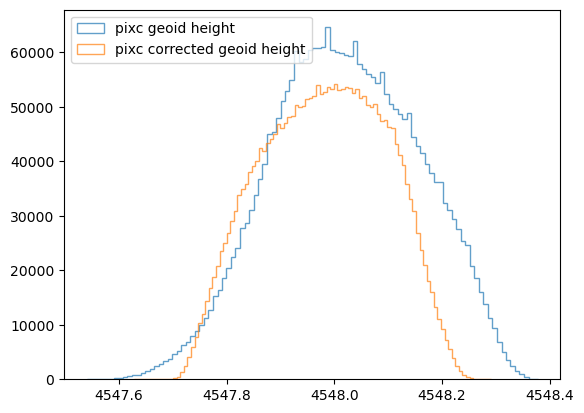

In [21]:
plt.hist(pixcs_height_ds[id].height_geoid.values.ravel(), bins=100, 
                        alpha=0.7, histtype='step', label='pixc geoid height');
plt.hist(pixcs_height_ds[id].height_geoid_cor.values.ravel(), bins=100, 
                        alpha=0.7, histtype='step', label='pixc corrected geoid height');
plt.legend();
